Found 4 signals, visualizing the first 4: ['signal_0', 'signal_1', 'signal_2', 'signal_3']


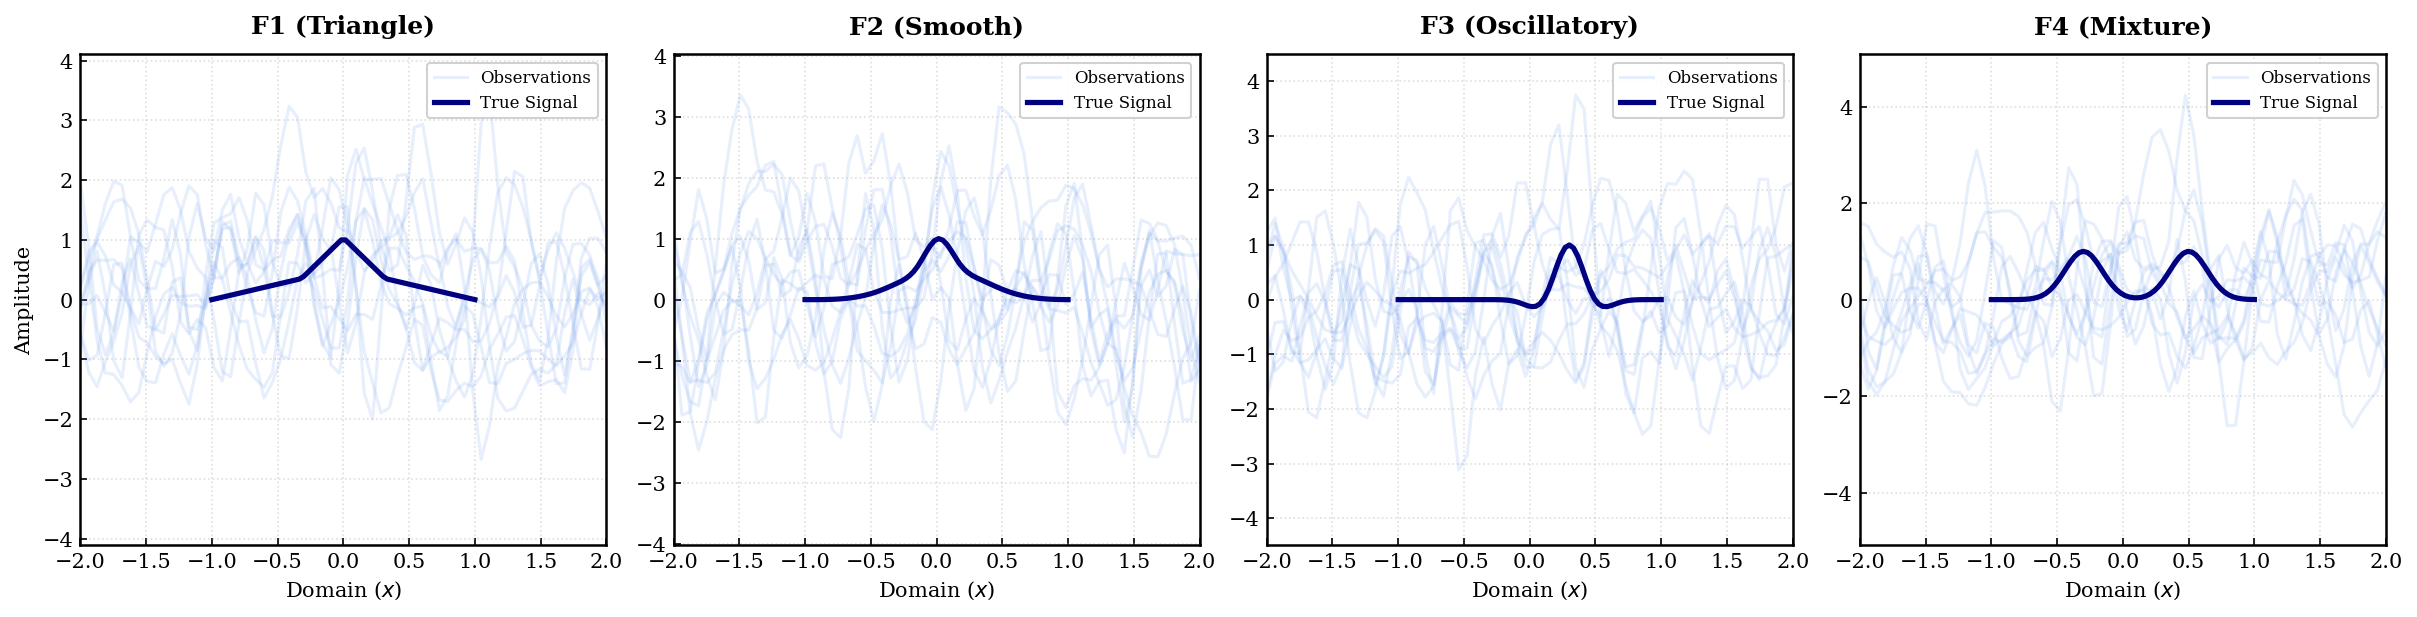

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# Visualization Settings
# ==========================================
DATA_PATH = "./data/obs_dataset_uniform_compare_preview.npz"

# Style configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def visualize_previews(file_path):
    """
    Loads observation data from an .npz file and visualizes the first 4 signals.
    
    This function reads the dataset, extracts the true signal and noisy observations,
    and plots them side-by-side. It assumes the data contains at least 4 signals
    corresponding to F1, F2, F3, and F4.

    Args:
        file_path (str): The relative or absolute path to the .npz data file.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    # 1. Load Data
    with np.load(file_path, allow_pickle=True) as data:
        # Get all keys sorted (e.g., signal_0, signal_1...)
        all_keys = sorted(list(data.keys()))
        
        # Limit to the first 4 signals only
        keys = all_keys[:4]
        n_plots = len(keys)
        
        print(f"Found {len(all_keys)} signals, visualizing the first {n_plots}: {keys}")
        
        if n_plots == 0:
            print("No signals found in the file.")
            return

        # 2. Setup Plot
        # Dynamic width based on number of plots
        fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), constrained_layout=True)
        
        if n_plots == 1:
            axes = [axes]
            
        # 3. Iterate and Plot
        for i, key in enumerate(keys):
            ax = axes[i]
            
            # Extract the dictionary for this signal
            item = data[key].item()
            
            y_true = item['y_true']
            y_obs = item['y_obs']
            f_grid = item['f_grid'] # Grid for True Signal
            t_grid = item['t_grid'] # Grid for Observations
            
            # --- Plot Observations (First 10 lines) ---
            n_obs_to_plot = min(10, y_obs.shape[0])
            for j in range(n_obs_to_plot):
                label = "Observations" if j == 0 else None
                ax.plot(t_grid, y_obs[j], 
                        color='cornflowerblue', 
                        alpha=0.15,       # Transparency
                        linewidth=1.5,
                        label=label)
                
            # --- Plot True Signal ---
            ax.plot(f_grid, y_true, 
                    color='navy',         # Deep Blue
                    linewidth=2.5, 
                    zorder=10,            # Ensure it stays on top
                    label="True Signal")
            
            # --- Aesthetics & Limits ---
            ax.set_xlim(-2, 2)
            y_max = np.max(np.abs(y_obs[:n_obs_to_plot])) * 1.2
            ax.set_ylim(-y_max, y_max)
            
            # Titles
            # Hardcoded names for the first 4 signals
            names = ["F1 (Triangle)", "F2 (Smooth)", "F3 (Oscillatory)", "F4 (Mixture)"]
            
            if i < len(names):
                title_text = names[i]
            else:
                title_text = f"Sample {i}: {key}"
                 
            ax.set_title(title_text, fontsize=12, fontweight='bold', pad=10)
            
            # Labels: Changed domain from t to x
            ax.set_xlabel("Domain ($x$)", fontsize=10)
            if i == 0:
                ax.set_ylabel("Amplitude", fontsize=10)
                
            # Grid
            ax.grid(True, linestyle=':', alpha=0.4)
            
            # Legend
            ax.legend(loc='upper right', fontsize=8, framealpha=0.9)

    plt.show()

# Run the function
if __name__ == "__main__":
    visualize_previews(DATA_PATH)

<>:148: SyntaxWarning: invalid escape sequence '\i'
<>:148: SyntaxWarning: invalid escape sequence '\i'
/var/folders/0d/84dbvs0x5t31prdwwtjl4hqm0000gn/T/ipykernel_64500/3114153045.py:148: SyntaxWarning: invalid escape sequence '\i'
  text_str = f"$L_2 = {l2:.2f}$\n$L_\infty = {linf:.2f}$"


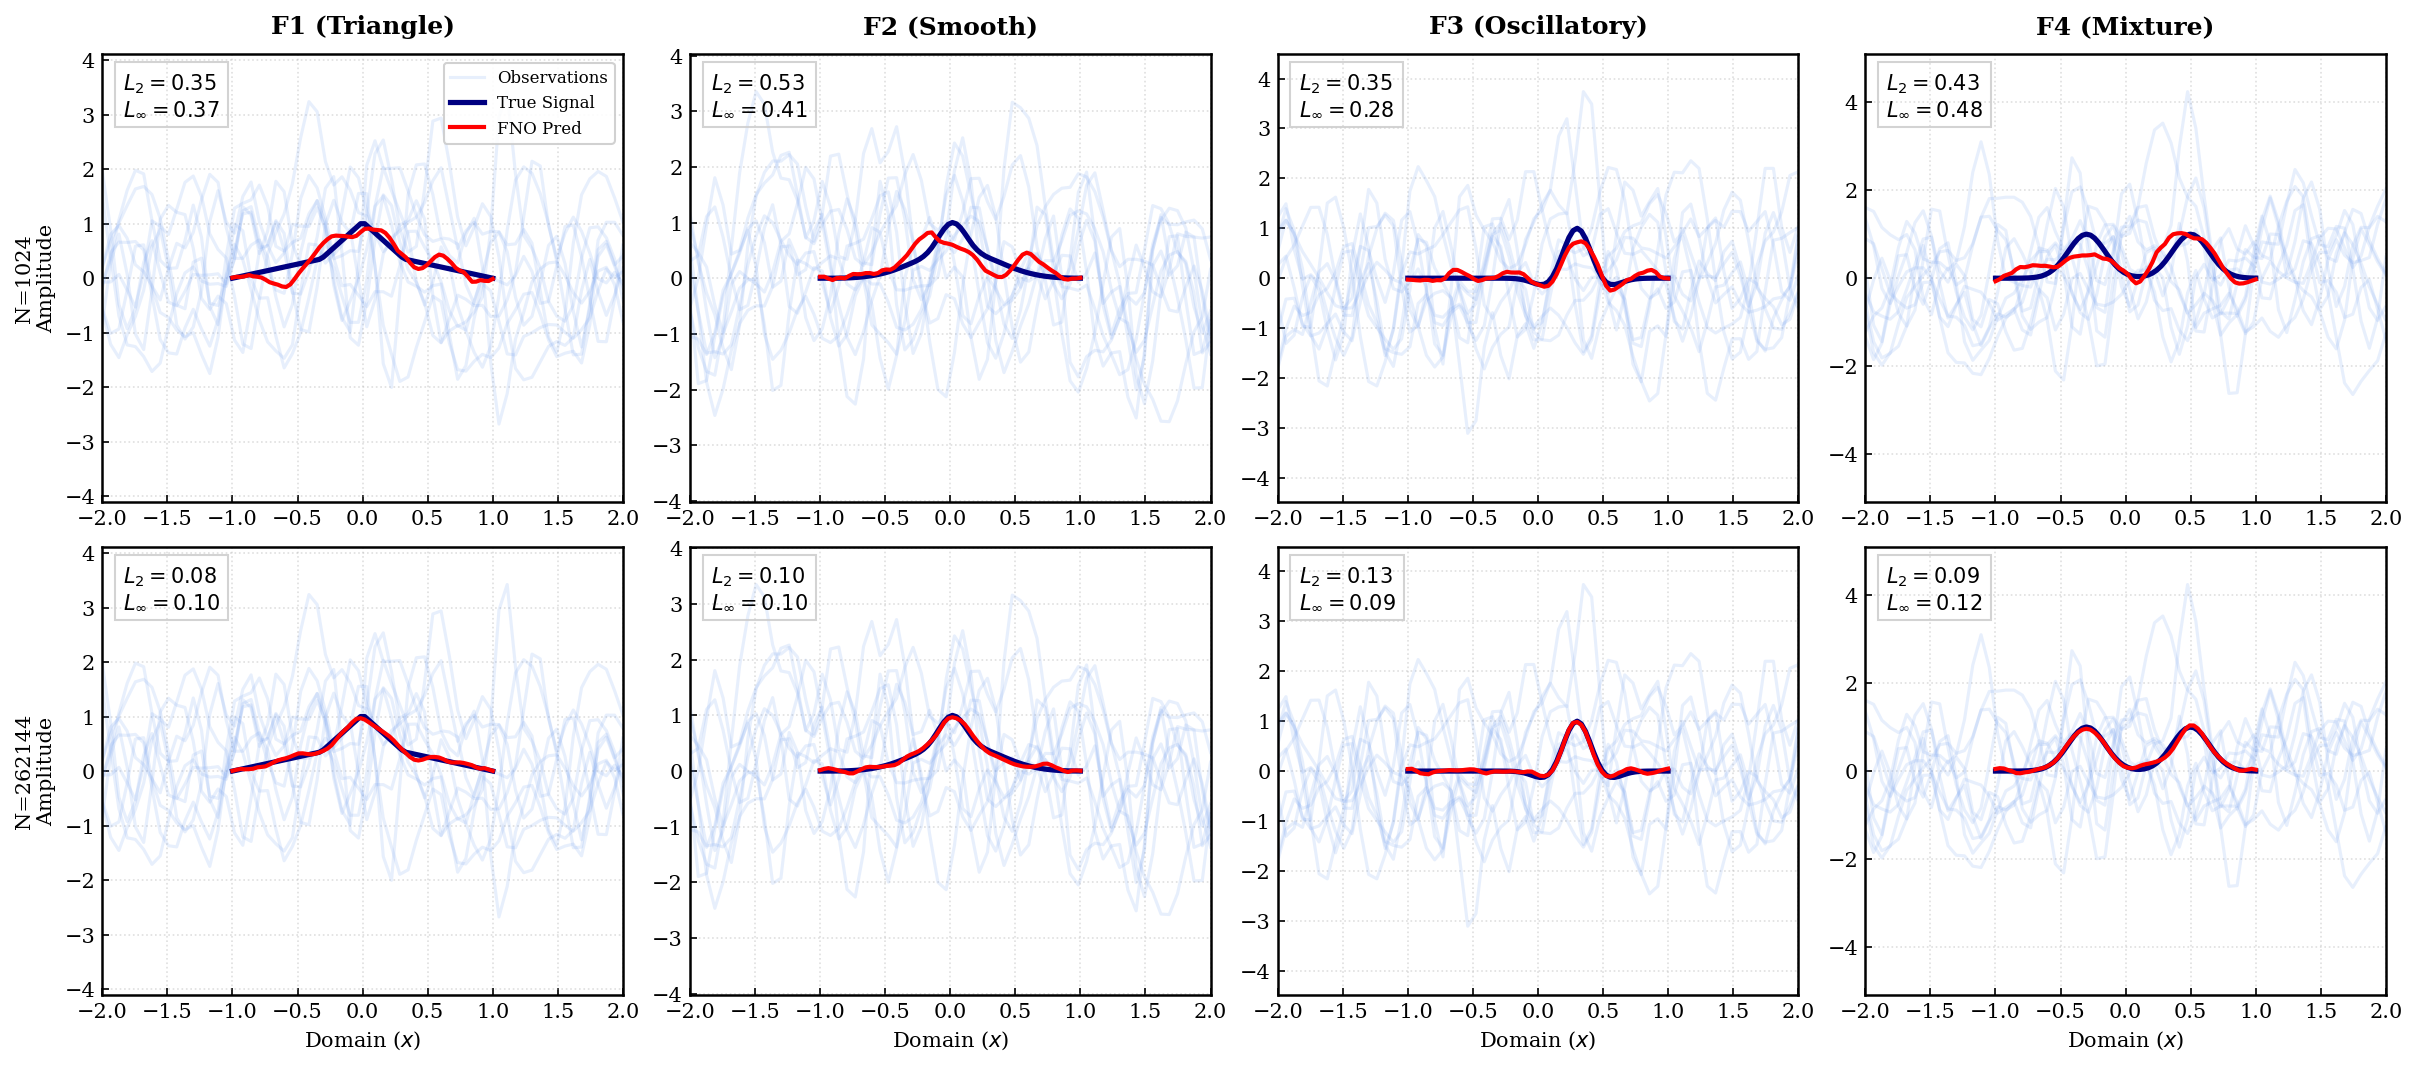

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import json

# ==========================================
# Visualization Settings
# ==========================================
PREVIEW_PATH = "./data/obs_dataset_uniform_compare_preview.npz"
RESULTS_DIR = "./fno_results/uniform"

# Target N values for the rows
TARGET_NS = [1024, 262144]

# Style configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def extract_n_from_path(path):
    """Extract N samples from folder name string like 'mra_fno_n_1024'"""
    match = re.search(r'_(\d+)$', os.path.basename(path))
    if match:
        return int(match.group(1))
    return 0

def get_metrics(exp_path, func_index):
    """
    Extracts L2 and Linf relative loss from detailed_summary.json for a specific function.
    func_index: 0 for f1, 1 for f2, etc.
    """
    json_path = os.path.join(exp_path, "detailed_summary.json")
    if not os.path.exists(json_path):
        return None
    
    try:
        with open(json_path, 'r') as f:
            summary = json.load(f)
        
        test_funcs = summary.get("test_functions", {})
        
        # Match keys starting with f1, f2, etc. (e.g., "f1_ord", "f3_super")
        prefix = f"f{func_index + 1}"
        target_key = None
        for key in test_funcs.keys():
            if key.startswith(prefix):
                target_key = key
                break
        
        if target_key:
            return test_funcs[target_key]
            
    except Exception as e:
        print(f"Error reading metrics from {json_path}: {e}")
        
    return None

def visualize_results():
    # 1. Load Preview Data (Observations & True Signals)
    if not os.path.exists(PREVIEW_PATH):
        print(f"Error: Preview file not found at {PREVIEW_PATH}")
        return

    with np.load(PREVIEW_PATH, allow_pickle=True) as preview_data:
        # Get keys for F1-F4
        preview_keys = sorted(list(preview_data.keys()))[:4]
        
        if len(preview_keys) < 4:
            print(f"Error: Expected at least 4 signals in preview file, found {len(preview_keys)}")
            return

        # 2. Find Experiment Folders
        exp_dirs = glob.glob(os.path.join(RESULTS_DIR, "*"))
        exp_map = {} # Map N -> path
        
        for d in exp_dirs:
            if os.path.isdir(d):
                n_val = extract_n_from_path(d)
                if n_val in TARGET_NS:
                    exp_map[n_val] = d
        
        # Check if we found the required experiments
        for n in TARGET_NS:
            if n not in exp_map:
                print(f"Warning: Results for N={n} not found in {RESULTS_DIR}")

        # 3. Setup Canvas (2 Rows x 4 Cols)
        # Fixed layout: Row 1 = N=1024, Row 2 = N=262144
        rows = len(TARGET_NS)
        cols = 4
        fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows), constrained_layout=True)
        
        col_titles = ["F1 (Triangle)", "F2 (Smooth)", "F3 (Oscillatory)", "F4 (Mixture)"]
        
        # 4. Iterate Rows (N values)
        for row_idx, n_val in enumerate(TARGET_NS):
            exp_path = exp_map.get(n_val)
            
            y_pred_compare = None
            if exp_path and os.path.exists(os.path.join(exp_path, "estimations.npz")):
                est_data = np.load(os.path.join(exp_path, "estimations.npz"))
                y_pred_compare = est_data['y_pred_compare'] # Shape usually (4, grid_len)

            # Iterate Columns (Functions F1-F4)
            for col_idx in range(cols):
                ax = axes[row_idx, col_idx]
                
                # --- Load Signal Data ---
                key = preview_keys[col_idx]
                item = preview_data[key].item()
                
                y_true = item['y_true']
                y_obs = item['y_obs']
                f_grid = item['f_grid']
                t_grid = item['t_grid']

                # --- Plot Observations (Background) ---
                n_obs_plot = min(10, y_obs.shape[0])
                for j in range(n_obs_plot):
                    label = "Observations" if (j == 0 and row_idx == 0 and col_idx == 0) else None
                    ax.plot(t_grid, y_obs[j], color='cornflowerblue', alpha=0.15, linewidth=1.5, label=label)
                
                # --- Plot True Signal ---
                label_true = "True Signal" if (row_idx == 0 and col_idx == 0) else None
                ax.plot(f_grid, y_true, color='navy', linewidth=2.5, zorder=5, label=label_true)

                # --- Plot Prediction ---
                if y_pred_compare is not None and col_idx < len(y_pred_compare):
                    y_est = y_pred_compare[col_idx]
                    label_pred = "FNO Pred" if (row_idx == 0 and col_idx == 0) else None
                    ax.plot(f_grid, y_est, color='red', linewidth=2.0, zorder=6, label=label_pred)

                # --- Metrics Text (Top Left) ---
                if exp_path:
                    metrics = get_metrics(exp_path, col_idx)
                    if metrics:
                        l2 = metrics.get('l2', 0.0)
                        linf = metrics.get('linf', 0.0)
                        text_str = f"$L_2 = {l2:.2f}$\n$L_\infty = {linf:.2f}$"
                        
                        # Add text box
                        ax.text(0.04, 0.96, text_str, transform=ax.transAxes, 
                                fontsize=10, verticalalignment='top',
                                bbox=dict(boxstyle='square,pad=0.4', facecolor='none', alpha=0.85, edgecolor='0.8'))

                # --- Aesthetics ---
                ax.set_xlim(-2, 2)
                
                # Dynamic Y-limit
                y_max = np.max(np.abs(y_obs[:n_obs_plot])) * 1.2
                ax.set_ylim(-y_max, y_max)
                
                # Column Titles (Top Row Only)
                if row_idx == 0:
                    ax.set_title(col_titles[col_idx], fontsize=12, fontweight='bold', pad=10)
                
                # Row Labels (Left Column Only)
                if col_idx == 0:
                    ax.set_ylabel(f"N={n_val}\nAmplitude", fontsize=10, fontweight='normal')
                
                # X Labels (Bottom Row Only)
                if row_idx == rows - 1:
                    ax.set_xlabel("Domain ($x$)", fontsize=10)
                
                ax.grid(True, linestyle=':', alpha=0.4)
                
                # Legend on the very first plot only
                if row_idx == 0 and col_idx == 0:
                    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)

    plt.show()

if __name__ == "__main__":
    visualize_results()

<>:128: SyntaxWarning: invalid escape sequence '\i'
<>:128: SyntaxWarning: invalid escape sequence '\i'
/var/folders/0d/84dbvs0x5t31prdwwtjl4hqm0000gn/T/ipykernel_64500/718281038.py:128: SyntaxWarning: invalid escape sequence '\i'
  titles = ["$L_2$ Relative Error Decay", "$L_\infty$ Relative Error Decay"]


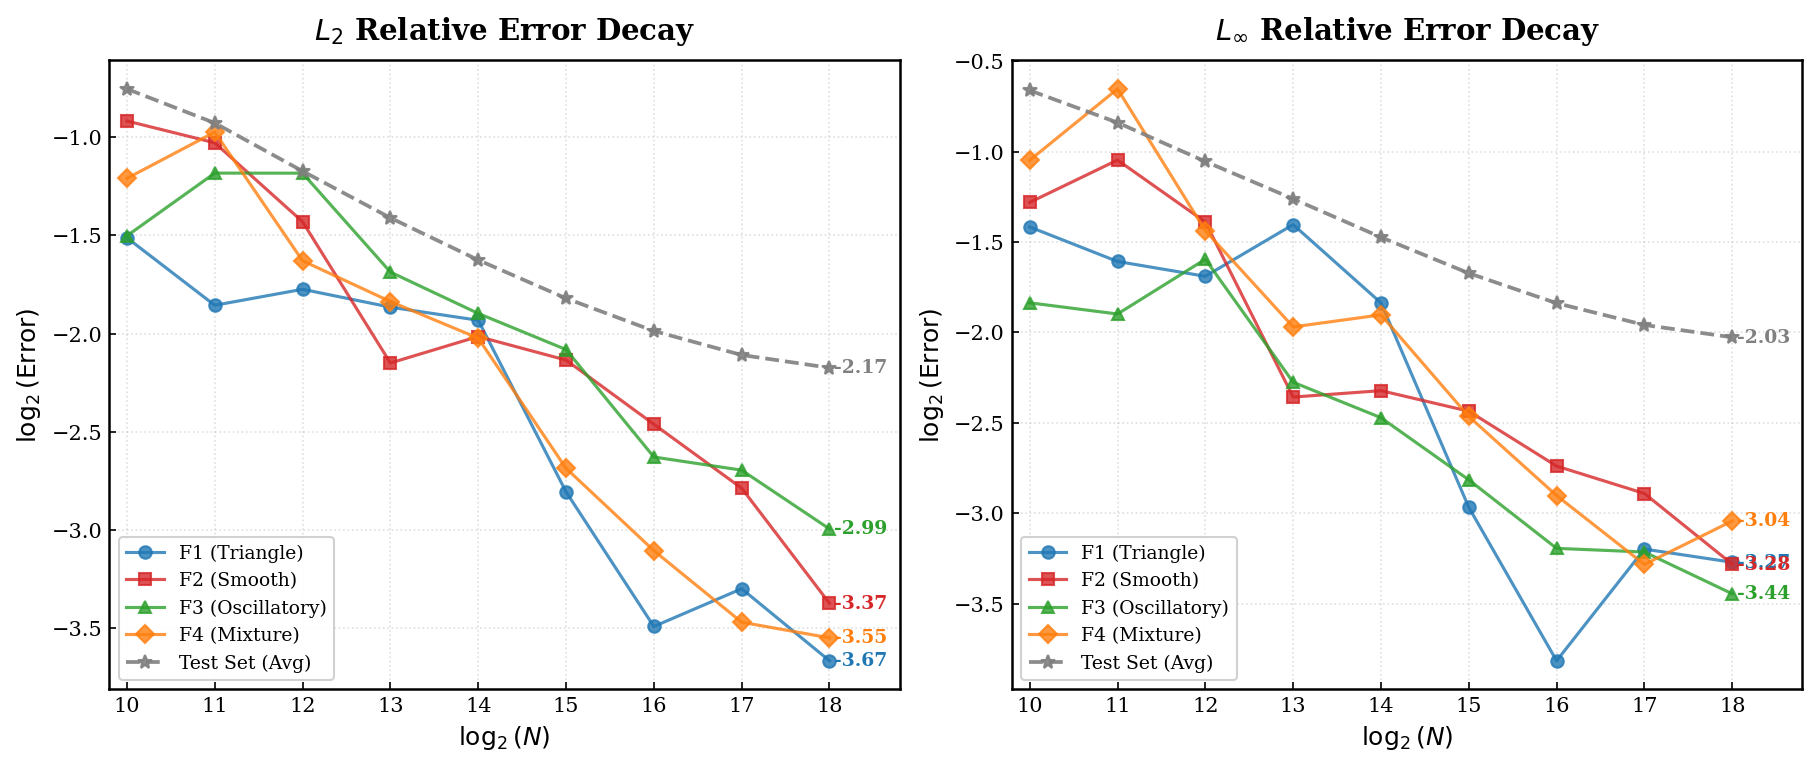

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import json

# ==========================================
# Settings
# ==========================================
RESULTS_DIR = "./fno_results/uniform"
MIN_N = 2**10  # 1024
MAX_N = 2**18  # 262144

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Function metadata for F1-F4
FUNC_META = [
    {"key_prefix": "f1", "label": "F1 (Triangle)", "color": "#1f77b4", "marker": "o"}, # Blue
    {"key_prefix": "f2", "label": "F2 (Smooth)", "color": "#d62728", "marker": "s"},   # Red
    {"key_prefix": "f3", "label": "F3 (Oscillatory)", "color": "#2ca02c", "marker": "^"}, # Green
    {"key_prefix": "f4", "label": "F4 (Mixture)", "color": "#ff7f0e", "marker": "D"}    # Orange
]

# Metadata for the Test Set 
TEST_META = {
    "label": "Test Set (Avg)", 
    "color": "grey", 
    "marker": "*", 
    "linestyle": "--"
}

def extract_n_from_path(path):
    """Extract N from folder name."""
    match = re.search(r'_(\d+)$', os.path.basename(path))
    if match:
        return int(match.group(1))
    return 0

def load_metrics():
    """
    Scans directories and returns a structure:
    data[func_idx] = { 'n': [], 'l2': [], 'linf': [] }
    data['test']   = { 'n': [], 'l2': [], 'linf': [] }
    """
    # Initialize storage for F1-F4 and Test Set
    data = {i: {'n': [], 'l2': [], 'linf': []} for i in range(4)}
    data['test'] = {'n': [], 'l2': [], 'linf': []}
    
    exp_dirs = glob.glob(os.path.join(RESULTS_DIR, "*"))
    
    for d in exp_dirs:
        if not os.path.isdir(d):
            continue
            
        n_val = extract_n_from_path(d)
        if n_val < MIN_N or n_val > MAX_N:
            continue
            
        json_path = os.path.join(d, "detailed_summary.json")
        if not os.path.exists(json_path):
            continue
            
        try:
            with open(json_path, 'r') as f:
                summary = json.load(f)
            
            # 1. Extract Test Set (Global Metrics)
            val_l2 = summary.get("best_val_l2_rel")
            val_linf = summary.get("best_val_linf_rel")
            
            if val_l2 is not None and val_linf is not None:
                data['test']['n'].append(n_val)
                data['test']['l2'].append(val_l2)
                data['test']['linf'].append(val_linf)

            # 2. Extract Individual Functions F1-F4
            test_funcs = summary.get("test_functions", {})
            for i, meta in enumerate(FUNC_META):
                # Find key in json (e.g., "f1_ord", "f1_super" etc.)
                prefix = meta["key_prefix"]
                target_key = None
                for k in test_funcs.keys():
                    if k.startswith(prefix):
                        target_key = k
                        break
                
                if target_key:
                    metrics = test_funcs[target_key]
                    data[i]['n'].append(n_val)
                    data[i]['l2'].append(metrics['l2'])
                    data[i]['linf'].append(metrics['linf'])
                    
        except Exception as e:
            print(f"Skipping {d}: {e}")
            
    # Sort data by N for all keys (0-3 and 'test')
    for key in list(data.keys()):
        if not data[key]['n']:
            continue
        sorted_lists = sorted(zip(data[key]['n'], data[key]['l2'], data[key]['linf']))
        n, l2, linf = zip(*sorted_lists)
        data[key]['n'] = np.array(n)
        data[key]['l2'] = np.array(l2)
        data[key]['linf'] = np.array(linf)
        
    return data

def plot_convergence():
    data = load_metrics()
    
    has_data = any(len(data[k]['n']) > 0 for k in data.keys())
    if not has_data:
        print("No valid data found in range.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    
    titles = ["$L_2$ Relative Error Decay", "$L_\infty$ Relative Error Decay"]
    metric_keys = ['l2', 'linf']
    
    for ax_idx, ax in enumerate(axes):
        metric_key = metric_keys[ax_idx]
        
        # --- 1. Plot F1 - F4 ---
        for func_idx in range(4):
            meta = FUNC_META[func_idx]
            dataset = data[func_idx]
            
            if len(dataset['n']) == 0:
                continue
                
            # Log2 Transformation
            x = np.log2(dataset['n'])
            y = np.log2(dataset[metric_key])
            
            # Plot Line
            ax.plot(x, y, 
                    label=meta['label'], 
                    color=meta['color'], 
                    marker=meta['marker'], 
                    markersize=6, 
                    linewidth=1.5,
                    alpha=0.8)
            
            # Annotate the last point
            ax.text(x[-1] + 0.05, y[-1], f"{y[-1]:.2f}", 
                    fontsize=9, color=meta['color'],
                    verticalalignment='center', fontweight='bold')

        # --- 2. Plot Test Set ---
        test_dataset = data['test']
        if len(test_dataset['n']) > 0:
            x_test = np.log2(test_dataset['n'])
            y_test = np.log2(test_dataset[metric_key])
            
            ax.plot(x_test, y_test,
                    label=TEST_META['label'],
                    color=TEST_META['color'],
                    marker=TEST_META['marker'],
                    linestyle=TEST_META['linestyle'],
                    markersize=7,
                    linewidth=1.8, # Slightly thicker
                    alpha=0.9,
                    zorder=10) # Put on top
            
            # Annotate Test Set
            ax.text(x_test[-1] + 0.05, y_test[-1], f"{y_test[-1]:.2f}", 
                    fontsize=9, color=TEST_META['color'],
                    verticalalignment='center', fontweight='bold')

        # Aesthetics
        ax.set_title(titles[ax_idx], fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel(r"$\log_{2}(N)$", fontsize=12)
        ax.set_ylabel(r"$\log_{2}(\text{Error})$", fontsize=12)
        
        ax.grid(True, which="both", ls=":", alpha=0.4)
        
        # Adjust x-lim to make room for annotations
        all_x = []
        for k in data.keys():
            if len(data[k]['n']) > 0:
                all_x.extend(np.log2(data[k]['n']))
        
        if all_x:
            ax.set_xlim(np.min(all_x) - 0.2, np.max(all_x) + 0.8)
        
        # Legend
        ax.legend(fontsize=9, framealpha=0.9, loc='lower left')

    plt.show()

if __name__ == "__main__":
    plot_convergence()

<>:121: SyntaxWarning: invalid escape sequence '\i'
<>:124: SyntaxWarning: invalid escape sequence '\i'
<>:121: SyntaxWarning: invalid escape sequence '\i'
<>:124: SyntaxWarning: invalid escape sequence '\i'
/var/folders/0d/84dbvs0x5t31prdwwtjl4hqm0000gn/T/ipykernel_64500/318160095.py:121: SyntaxWarning: invalid escape sequence '\i'
  f"$L_\infty={m_fno_linf:.2f}$\n\n"
/var/folders/0d/84dbvs0x5t31prdwwtjl4hqm0000gn/T/ipykernel_64500/318160095.py:124: SyntaxWarning: invalid escape sequence '\i'
  f"$L_\infty={m_post_linf:.2f}$"



>>> Loading Compare Set from posterior_results_compare.npz...
    Found 4 samples total.

>>> Loading Test Set from posterior_results_test.npz...
    Found 32 samples total.

=== Compare Set Summary (Over 4 samples) ===
  FNO       : Avg L2=0.0966 | Avg Linf=0.1050
  Posterior : Avg L2=0.0939 | Avg Linf=0.0884

=== Test Set Summary (Over 32 samples) ===
  FNO       : Avg L2=0.3174 | Avg Linf=0.3700
  Posterior : Avg L2=0.2879 | Avg Linf=0.3403

Saving visualization to posterior_evaluation_summary.png...


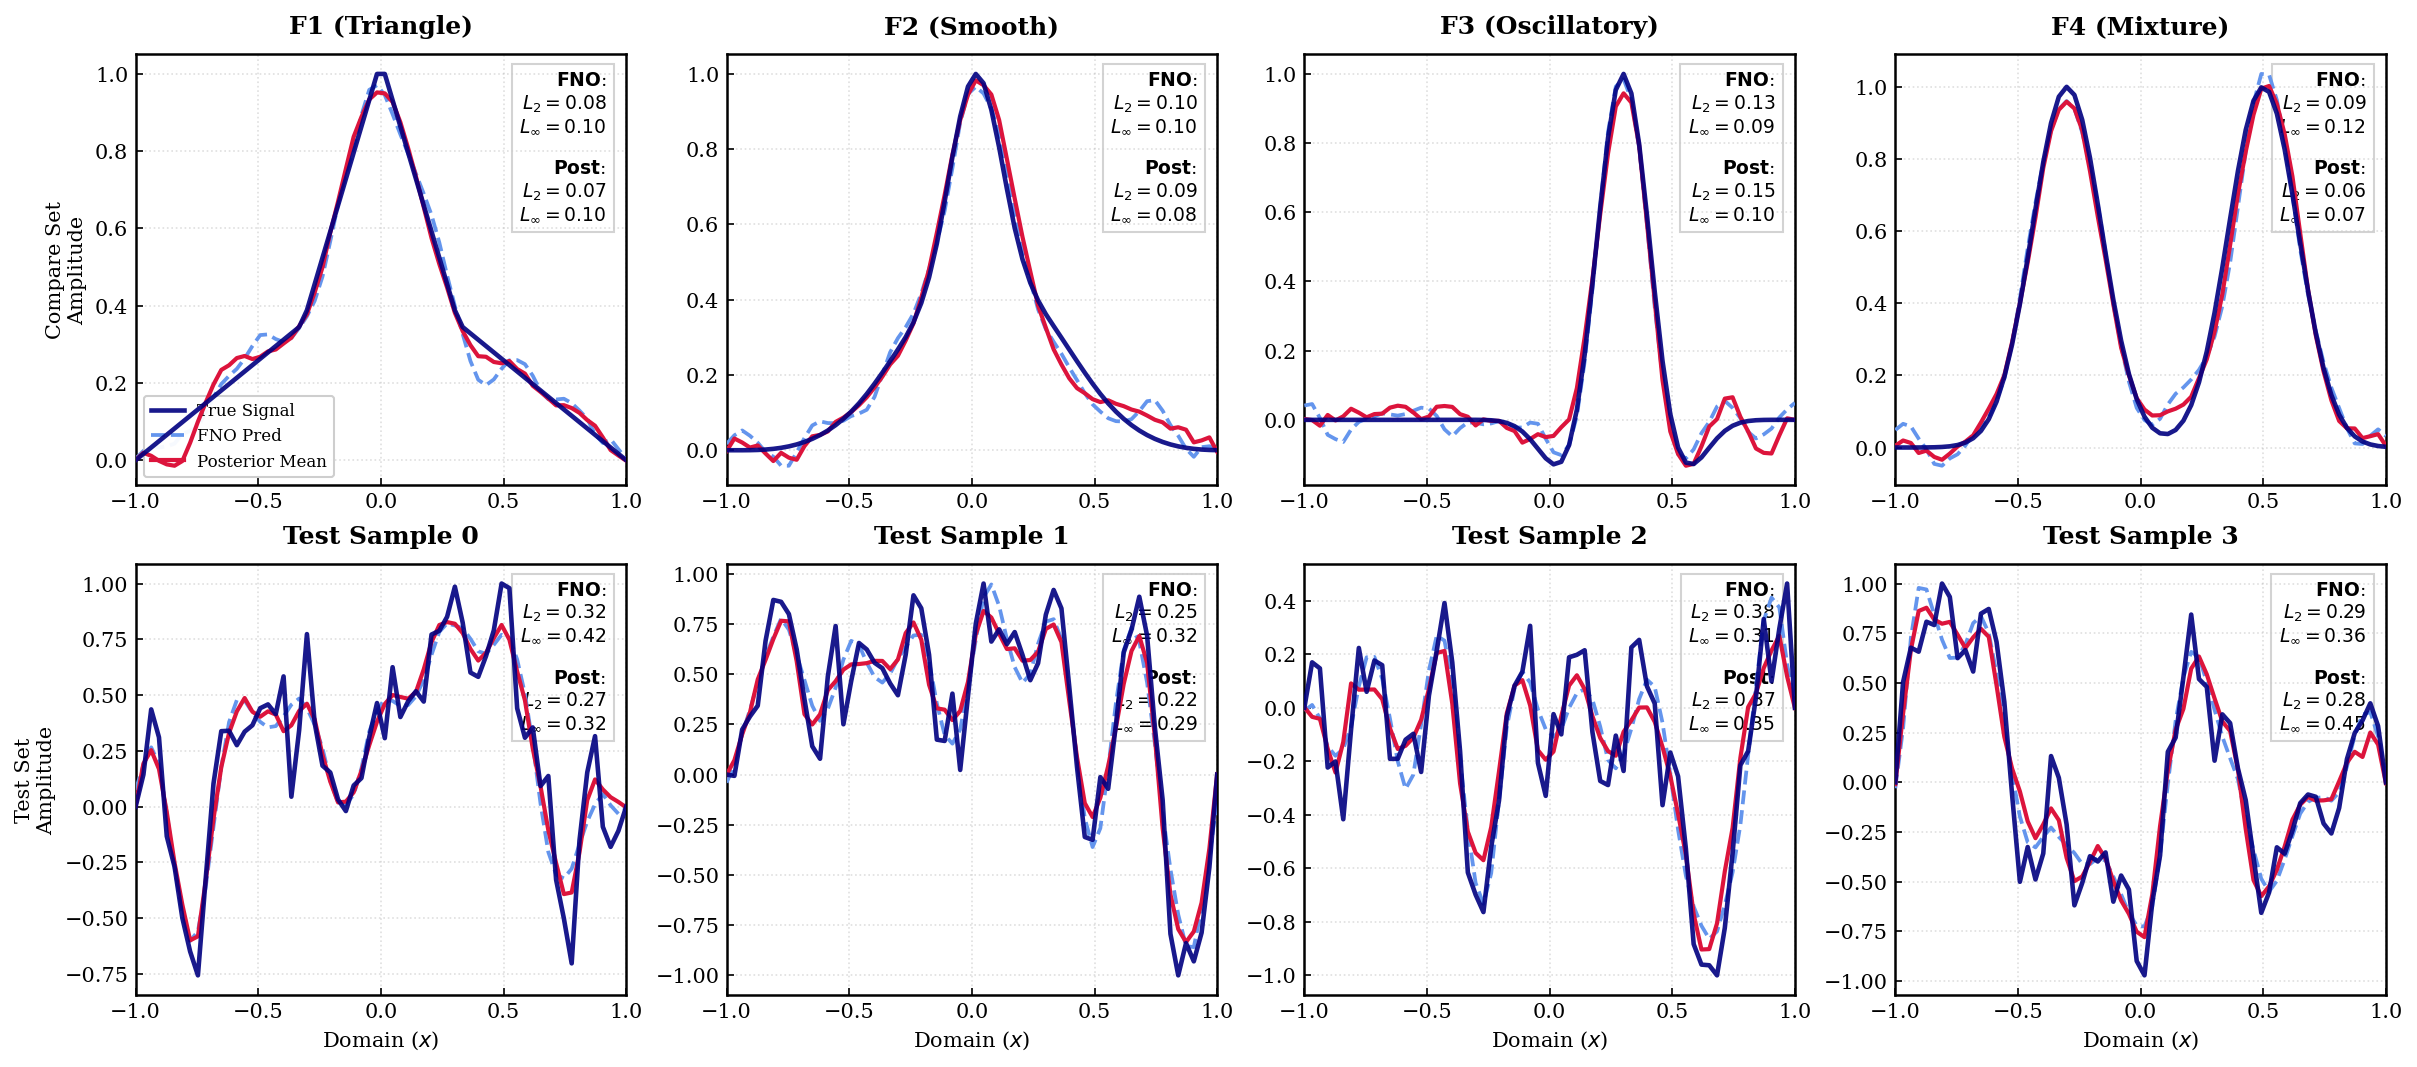

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# Settings
# ==========================================
PATH_COMPARE = "posterior_results_compare.npz"
PATH_TEST = "posterior_results_test.npz"
SAVE_IMG_PATH = "posterior_evaluation_summary.png"

# Plotting Style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def rel_l2(pred, true):
    """Compute Relative L2 Error"""
    diff_norm = np.linalg.norm(pred - true)
    true_norm = np.linalg.norm(true)
    return diff_norm / (true_norm + 1e-12)

def rel_linf(pred, true):
    """Compute Relative L-infinity Error"""
    diff_max = np.max(np.abs(pred - true))
    true_max = np.max(np.abs(true))
    return diff_max / (true_max + 1e-12)

def process_dataset(data_path, dataset_name, axes_row=None, plot_limit=4):
    """
    Process a single dataset: compute metrics for all samples and plot the first few.
    
    Args:
        data_path (str): Path to the .npz file.
        dataset_name (str): Name for display/logging.
        axes_row (list): List of axes to plot on (one row). If None, no plotting.
        plot_limit (int): Number of images to plot.
    
    Returns:
        dict: Dictionary containing lists of metrics.
    """
    if not os.path.exists(data_path):
        print(f"Error: Results file not found at {data_path}")
        return {}, {}

    print(f"\n>>> Loading {dataset_name} from {data_path}...")
    data = np.load(data_path, allow_pickle=True)
    
    # Sort Keys (e.g., signal_0, signal_1...) based on the index number
    keys = sorted(list(data.keys()), key=lambda x: int(x.split('_')[1]))
    n_total = len(keys)
    print(f"    Found {n_total} samples total.")

    # Accumulators for metrics
    metrics = {
        "fno_l2": [], "fno_linf": [],
        "post_l2": [], "post_linf": []
    }

    # Iterate through all samples to compute metrics
    for i, key in enumerate(keys):
        item = data[key].item()
        
        y_true = item['ground_truth']
        y_fno = item['fno_pred']
        y_post = item['posterior_mean']
        
        # Calculate Metrics
        m_fno_l2 = rel_l2(y_fno, y_true)
        m_fno_linf = rel_linf(y_fno, y_true)
        m_post_l2 = rel_l2(y_post, y_true)
        m_post_linf = rel_linf(y_post, y_true)
        
        metrics["fno_l2"].append(m_fno_l2)
        metrics["fno_linf"].append(m_fno_linf)
        metrics["post_l2"].append(m_post_l2)
        metrics["post_linf"].append(m_post_linf)

        # --- Plotting ---
        if axes_row is not None and i < plot_limit:
            ax = axes_row[i]
            
            # Create Grid
            L = y_true.shape[-1]
            x_grid = np.linspace(-1, 1, L)
            
            # 1. Ground Truth
            ax.plot(x_grid, y_true, color='navy', linestyle='-', linewidth=2.2, 
                    label='True Signal', zorder=10, alpha=0.9)
            
            # 2. FNO (Cornflowerblue, background baseline)
            ax.plot(x_grid, y_fno, color='cornflowerblue', linestyle='--', linewidth=1.8, 
                    label='FNO Pred', zorder=5)
            
            # 3. Posterior (Crimson, highlighted result)
            ax.plot(x_grid, y_post, color='crimson', linestyle='-', linewidth=2.0, 
                    label='Posterior Mean', zorder=6)
            
            # Aesthetics
            idx_num = key.split('_')[1]
            
            # Title Selection
            if dataset_name == "Compare Set":
                names = ["F1 (Triangle)", "F2 (Smooth)", "F3 (Oscillatory)", "F4 (Mixture)"]
                title_str = names[i] if i < len(names) else f"Signal {idx_num}"
            else:
                title_str = f"Test Sample {idx_num}"

            ax.set_title(title_str, fontweight='bold', fontsize=12, pad=10)
            
            # --- Text Box (Updated Style & LaTeX format) ---
            text_str = (
                r"$\bf{FNO}$:" + "\n"
                f"$L_2={m_fno_l2:.2f}$\n"
                f"$L_\infty={m_fno_linf:.2f}$\n\n"
                r"$\bf{Post}$:" + "\n"
                f"$L_2={m_post_l2:.2f}$\n"
                f"$L_\infty={m_post_linf:.2f}$"
            )
            
            props = dict(boxstyle='square,pad=0.4', facecolor='none', alpha=0.85, edgecolor='0.8')
            
            ax.text(0.96, 0.96, text_str, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', horizontalalignment='right', 
                    bbox=props)
            
            ax.grid(True, linestyle=':', alpha=0.4)
            ax.set_xlim(-1, 1)
            
            # X-Axis Label (Domain x)
            if dataset_name == "Test Set": # Bottom row
                ax.set_xlabel("Domain ($x$)", fontsize=10)
            
            # Y-Axis Label (Amplitude, only on left-most column)
            if i == 0:
                ylabel = f"{dataset_name}\nAmplitude"
                ax.set_ylabel(ylabel, fontsize=10, fontweight='normal')
                
                # Legend (Only on the very first plot)
                if dataset_name == "Compare Set": 
                    ax.legend(loc='lower left', fontsize=8, framealpha=0.95)

    return metrics

def print_summary(name, metrics):
    """Print average metrics to console."""
    if not metrics['fno_l2']:
        return
    print(f"\n=== {name} Summary (Over {len(metrics['fno_l2'])} samples) ===")
    print(f"  FNO       : Avg L2={np.mean(metrics['fno_l2']):.4f} | Avg Linf={np.mean(metrics['fno_linf']):.4f}")
    print(f"  Posterior : Avg L2={np.mean(metrics['post_l2']):.4f} | Avg Linf={np.mean(metrics['post_linf']):.4f}")

# ==========================================
# Main Execution
# ==========================================

if __name__ == "__main__":
    # Setup Canvas: 2 Rows (Row1=Compare, Row2=Test), 4 Columns
    fig, axes = plt.subplots(2, 4, figsize=(16, 7), constrained_layout=True)

    # 1. Process Compare Set (Plot all 4)
    compare_metrics = process_dataset(
        PATH_COMPARE, "Compare Set", 
        axes_row=axes[0], 
        plot_limit=4
    )

    # 2. Process Test Set (Plot first 4, but compute stats for all)
    test_metrics = process_dataset(
        PATH_TEST, "Test Set", 
        axes_row=axes[1], 
        plot_limit=4
    )

    # 3. Print Final Averages to Console
    print_summary("Compare Set", compare_metrics)
    print_summary("Test Set", test_metrics)

    # Save
    print(f"\nSaving visualization to {SAVE_IMG_PATH}...")
    plt.savefig(SAVE_IMG_PATH)
    plt.show()

Loading data...
Saving visualization to uq_analysis_summary.png...


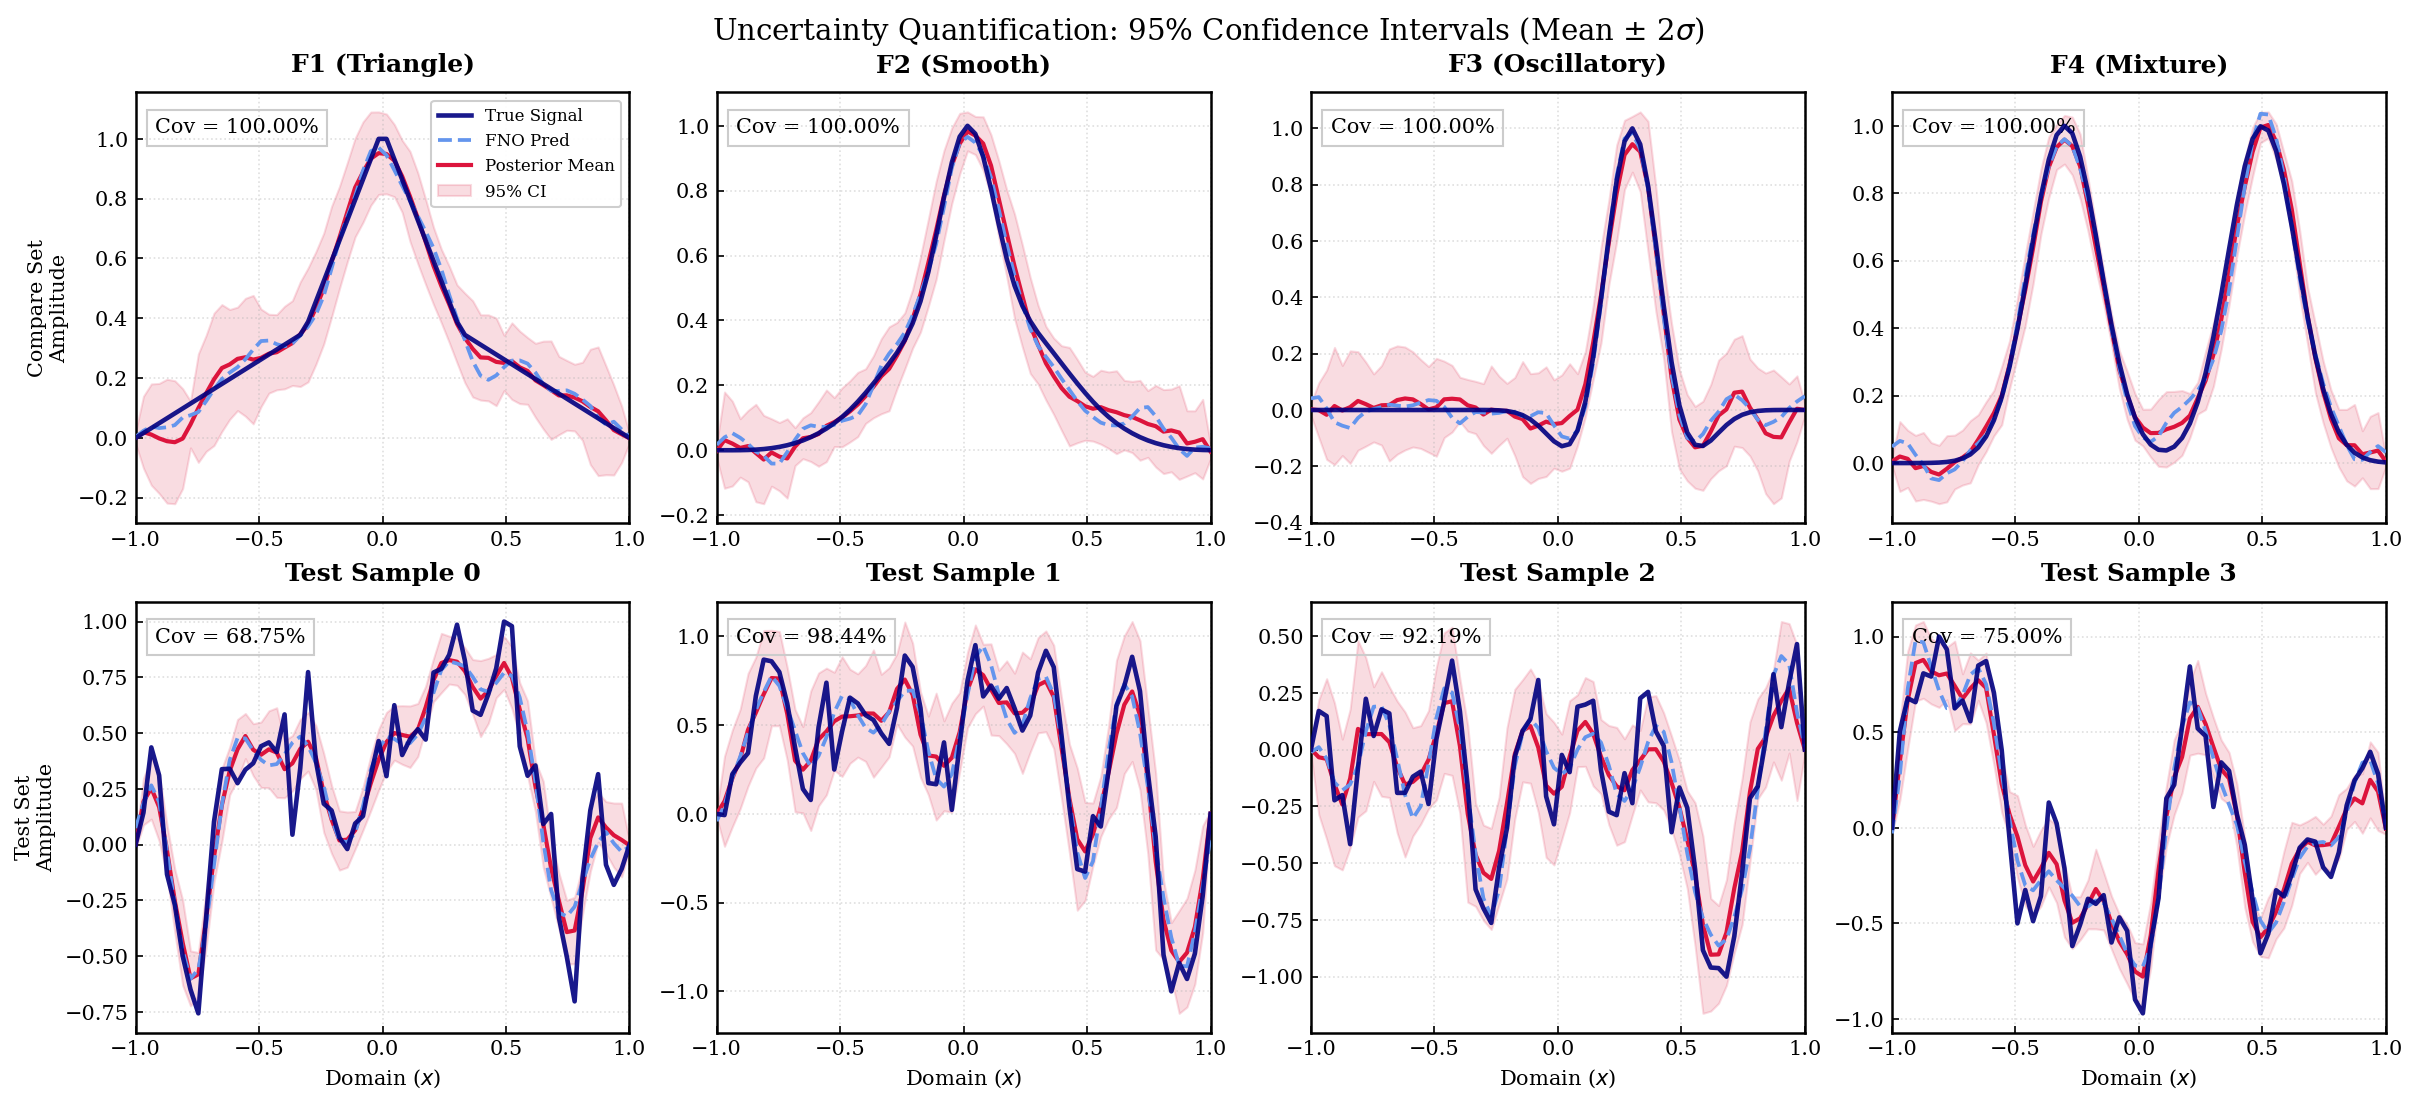


=== Global UQ Statistics ===
Data Sources: 4 Compare Samples + 32 Test Samples
Total Pixels Evaluated: 2304
------------------------------------------------
Target Coverage (95% CI) : 95.00%
Actual Coverage          : 85.63%
------------------------------------------------
Diagnosis: Under-confident (Uncertainty underestimated or Bias too large)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# Settings
# ==========================================
PATH_COMPARE = "posterior_results_compare.npz"
PATH_TEST = "posterior_results_test.npz"
SAVE_IMG_PATH = "uq_analysis_summary.png"

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def load_data(path):
    if not os.path.exists(path):
        print(f"Error: File not found at {path}")
        return {}
    return np.load(path, allow_pickle=True)

def process_and_plot(ax, item, title_str, show_legend=False, show_ylabel=False, dataset_name=""):
    """
    Plot UQ analysis for a single sample on the specified ax.
    Includes: Ground Truth, FNO Prediction, Posterior Mean, 95% CI.
    Also calculates and displays per-sample coverage.
    """
    # Extract Data
    mu = item['posterior_mean']
    std = item['posterior_std']
    true = item['ground_truth']
    fno = item['fno_pred']
    
    # Construct x-axis
    x_grid = np.linspace(-1, 1, len(mu))
    
    # 1. Ground Truth
    ax.plot(x_grid, true, color='navy', linestyle='-', linewidth=2.2, 
            label='True Signal', zorder=10, alpha=0.9)
    
    # 2. FNO Output (Cornflowerblue, dashed)
    ax.plot(x_grid, fno, color='cornflowerblue', linestyle='--', linewidth=1.8, 
            label='FNO Pred', zorder=9)
    
    # 3. Posterior Mean (Crimson, solid)
    ax.plot(x_grid, mu, color='crimson', linestyle='-', linewidth=2.0, 
            label='Posterior Mean', zorder=8)
    
    # 4. 95% Confidence Interval (Crimson shade, +/- 2 std)
    upper_bound = mu + 2*std
    lower_bound = mu - 2*std
    ax.fill_between(x_grid, lower_bound, upper_bound, color='crimson', alpha=0.15, 
                    label='95% CI', zorder=1)
    
    # --- Coverage Calculation & Text Box ---
    # Calculate percentage of true values within the confidence interval
    in_ci = (true >= lower_bound) & (true <= upper_bound)
    coverage = np.mean(in_ci) * 100
    
    # Text box style consistent with previous paper-style requests (Square box, light gray edge)
    text_str = f"Cov = {coverage:.2f}%"
    props = dict(boxstyle='square,pad=0.4', facecolor='none', edgecolor='0.8')
    
    # Place text at top-left
    ax.text(0.04, 0.94, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Aesthetics
    ax.set_title(title_str, fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.set_xlim(-1, 1)
    
    # Y-Label (Amplitude) - Only on the left-most plots
    if show_ylabel:
        ax.set_ylabel(f"{dataset_name}\nAmplitude", fontsize=10, fontweight='normal')

    # Legend - Only on the first plot of the first row usually, or as requested
    if show_legend:
        ax.legend(loc='upper right', fontsize=8, framealpha=0.95)

def main_uq_analysis():
    print("Loading data...")
    data_comp = load_data(PATH_COMPARE)
    data_test = load_data(PATH_TEST)
    
    if not data_comp or not data_test:
        return

    # Get Keys and Sort
    keys_comp = sorted([k for k in data_comp.keys() if k.startswith('signal') or k.startswith('Compare')], 
                       key=lambda x: int(x.split('_')[1]))
    keys_test = sorted([k for k in data_test.keys() if k.startswith('signal') or k.startswith('Test')], 
                       key=lambda x: int(x.split('_')[1]))
    
    # === 1. Plotting (2x4 Grid) ===
    fig, axes = plt.subplots(2, 4, figsize=(16, 7), constrained_layout=True)
    
    # Row 1: Compare Set (First 4)
    # Updated Names to match previous requirements
    fixed_names = ["F1 (Triangle)", "F2 (Smooth)", "F3 (Oscillatory)", "F4 (Mixture)"]
    
    for i in range(4):
        ax = axes[0, i]
        if i < len(keys_comp):
            key = keys_comp[i]
            item = data_comp[key].item()
            
            # Determine Title
            if i < len(fixed_names):
                title = fixed_names[i]
            else:
                title = key
                
            # Plot
            process_and_plot(
                ax, item, title, 
                show_legend=(i == 0), 
                show_ylabel=(i == 0), 
                dataset_name="Compare Set"
            )

    # Row 2: Test Set (First 4)
    for i in range(4):
        ax = axes[1, i]
        if i < len(keys_test):
            key = keys_test[i]
            item = data_test[key].item()
            idx_num = key.split('_')[1]
            title = f"Test Sample {idx_num}"
            
            # Plot
            process_and_plot(
                ax, item, title, 
                show_legend=False, 
                show_ylabel=(i == 0), 
                dataset_name="Test Set"
            )
            
            # X-Label (Domain x) - Only on bottom row
            ax.set_xlabel("Domain ($x$)", fontsize=10)

    # Super Title
    plt.suptitle(r"Uncertainty Quantification: 95% Confidence Intervals (Mean $\pm$ 2$\sigma$)", fontsize=14, y=1.03)
    
    print(f"Saving visualization to {SAVE_IMG_PATH}...")
    plt.savefig(SAVE_IMG_PATH, bbox_inches='tight')
    plt.show()

    # === 2. Global Statistical Analysis (Covering ALL samples) ===
    
    all_z_scores = []
    total_pixels = 0
    
    # Collect from Compare Set (All samples)
    for key in keys_comp:
        item = data_comp[key].item()
        mu, std, true = item['posterior_mean'], item['posterior_std'], item['ground_truth']
        # Z-score = (True - Mean) / Std
        z = (true - mu) / (std + 1e-12)
        all_z_scores.append(z)
        total_pixels += len(z)
        
    # Collect from Test Set (All samples)
    for key in keys_test:
        item = data_test[key].item()
        mu, std, true = item['posterior_mean'], item['posterior_std'], item['ground_truth']
        z = (true - mu) / (std + 1e-12)
        all_z_scores.append(z)
        total_pixels += len(z)
        
    # Concatenate arrays
    all_z_scores = np.concatenate(all_z_scores)
    
    print(f"\n=== Global UQ Statistics ===")
    print(f"Data Sources: {len(keys_comp)} Compare Samples + {len(keys_test)} Test Samples")
    print(f"Total Pixels Evaluated: {total_pixels}")
    
    # Calculate Coverage
    # Threshold for 95% CI is 1.96
    in_95_ci = np.abs(all_z_scores) <= 1.96
    coverage = np.mean(in_95_ci) * 100
    
    print(f"------------------------------------------------")
    print(f"Target Coverage (95% CI) : 95.00%")
    print(f"Actual Coverage          : {coverage:.2f}%")
    print(f"------------------------------------------------")
    
    if coverage < 90:
        print("Diagnosis: Under-confident (Uncertainty underestimated or Bias too large)")
    elif coverage > 99:
        print("Diagnosis: Over-confident (Uncertainty overestimated)")
    else:
        print("Diagnosis: Well-calibrated")

if __name__ == "__main__":
    main_uq_analysis()